# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [22]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


num_workers = 0
batch_size = 20
valid_size = 0.2

mean_channels = [0.485, 0.456, 0.406]
std_channels = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean_channels,std_channels)])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder('./landmark_images/train', transform=transform_train)
test_data = datasets.ImageFolder('./landmark_images/test', transform=transform_test)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader_scratch = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader_scratch = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader_scratch = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader_scratch, 'valid': valid_loader_scratch, 'test': test_loader_scratch}



**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1. The code is randomly cropping a section of the image and then resizing it to 224,244. I picked size 224 becasue is a very commonly used size. It is good point for not too much information as well as good amount of information.

2. I am doing colorjitter,horizontal flip, random rotation and also perspective. When people click photos, these augmentations seemed to be the logical ones, when I think about the data.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

C:\Users\saksh\.conda\envs\py3_env\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
Clipping input data to the valid range for imshow with RGB data ([0..1]

tensor([ 5, 38, 41, 28, 19, 19, 38, 23, 33, 18, 20, 34, 44, 17, 44, 10,  1, 49,
        27,  5])

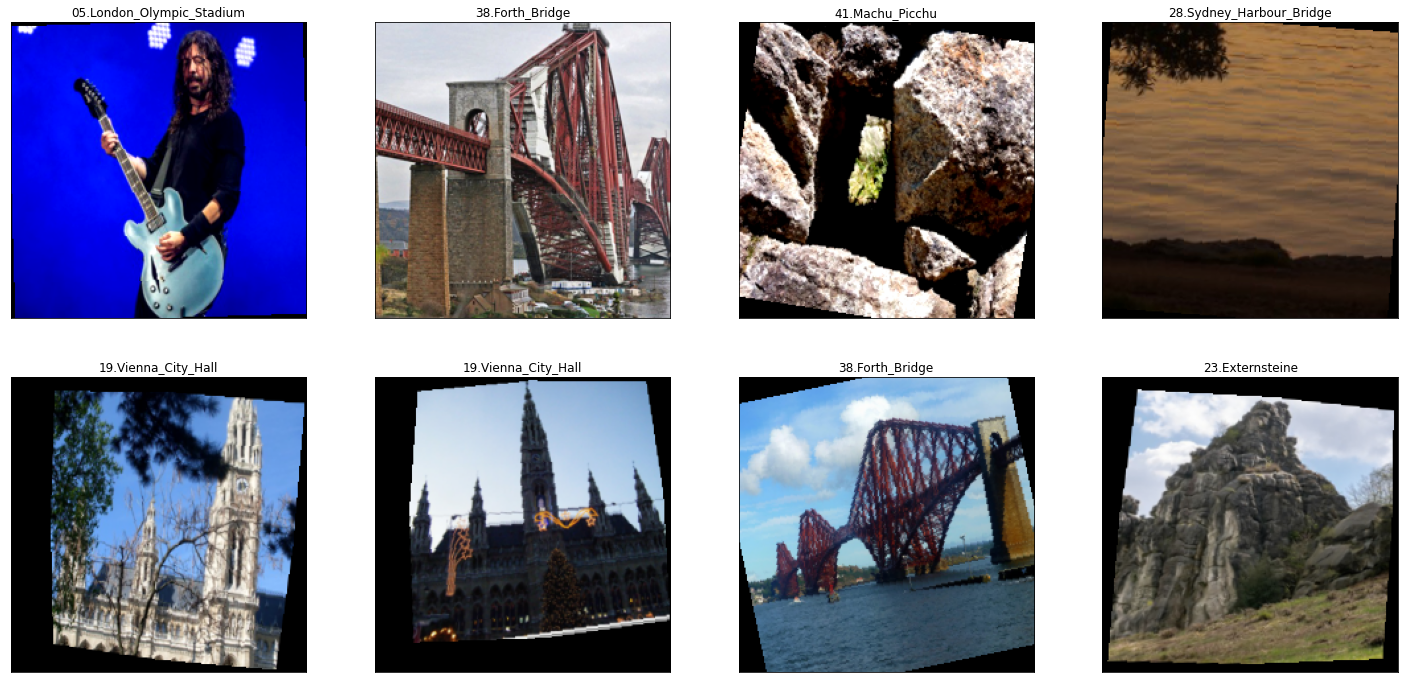

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
def imshow(img,std_channels,mean_channels):
    std_channels = np.array(std_channels).reshape(3,1,1)
    mean_channels = np.array(mean_channels).reshape(3,1,1)
    img = img * std_channels + mean_channels  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    
# obtain one batch of training images
dataiter = iter(train_loader_scratch)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = train_data.classes

# print(labels)
# train_data.classes
fig = plt.figure(figsize=(25, 25))
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
for idx in np.arange(8):
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx],std_channels,mean_channels)
    ax.set_title(classes[labels[idx]])
labels


### Initialize use_cuda variable

In [24]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [12]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.008, momentum = 0.9)
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [13]:

import torch.nn.functional as F
# define the CNN architecture
3
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*14*14,512) 
        self.fc2 = nn.Linear(512,50)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1,14*14*128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [14]:

from torchsummary import summary 

summary(model_scratch,(3,224,224))

C:\Users\saksh\.conda\envs\py3_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 16, 112, 112]           2,320
            Conv2d-4         [-1, 32, 112, 112]           4,640
         MaxPool2d-5           [-1, 32, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          18,496
         MaxPool2d-7           [-1, 64, 28, 28]               0
            Conv2d-8          [-1, 128, 28, 28]          73,856
         MaxPool2d-9          [-1, 128, 14, 14]               0
          Dropout-10                [-1, 25088]               0
           Linear-11                  [-1, 512]      12,845,568
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 50]          25,650
Total params: 12,970,978
Trainable para

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I used a structure similar to vgg model. Conv-Conv-pool-conv-pool-conv-pool...
I wanted to reduce the dimensions to 14*14 by pooling. I used conv-conv layer at first to match it with the layout of vgg network.

I also tried it with 28*28 size after last pooling, but that was increasing the number of parameters by a lot and the accuracy wasn't good with that. I read somewhere about batch norm. It said that it reduces the training time and the loss by a lot. But I am not sure how to use it and when to use it.

I used dropout to make sure all neurons participate actively


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [31]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
   

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
                
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [20]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)   

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.914499 	Validation Loss: 3.912713
Validation loss decreased (inf --> 3.912713).  Saving model ...
Epoch: 2 	Training Loss: 3.886054 	Validation Loss: 3.794270
Validation loss decreased (3.912713 --> 3.794270).  Saving model ...
Epoch: 3 	Training Loss: 3.796278 	Validation Loss: 3.730269
Validation loss decreased (3.794270 --> 3.730269).  Saving model ...
Epoch: 4 	Training Loss: 3.704387 	Validation Loss: 3.667042
Validation loss decreased (3.730269 --> 3.667042).  Saving model ...
Epoch: 5 	Training Loss: 3.649218 	Validation Loss: 3.668556
Epoch: 6 	Training Loss: 3.609242 	Validation Loss: 3.606548
Validation loss decreased (3.667042 --> 3.606548).  Saving model ...
Epoch: 7 	Training Loss: 3.583335 	Validation Loss: 3.532782
Validation loss decreased (3.606548 --> 3.532782).  Saving model ...
Epoch: 8 	Training Loss: 3.532348 	Validation Loss: 3.527113
Validation loss decreased (3.532782 --> 3.527113).  Saving model ...
Epoch: 9 	Training Loss: 3.486286 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [22]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
# num_epochs = 100
num_epochs = 20
#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.911229 	Validation Loss: 3.891303
Validation loss decreased (inf --> 3.891303).  Saving model ...
Epoch: 2 	Training Loss: 3.857046 	Validation Loss: 3.840008
Validation loss decreased (3.891303 --> 3.840008).  Saving model ...
Epoch: 3 	Training Loss: 3.805300 	Validation Loss: 3.746513
Validation loss decreased (3.840008 --> 3.746513).  Saving model ...
Epoch: 4 	Training Loss: 3.770890 	Validation Loss: 3.765745
Epoch: 5 	Training Loss: 3.753478 	Validation Loss: 3.696796
Validation loss decreased (3.746513 --> 3.696796).  Saving model ...
Epoch: 6 	Training Loss: 3.698144 	Validation Loss: 3.654508
Validation loss decreased (3.696796 --> 3.654508).  Saving model ...
Epoch: 7 	Training Loss: 3.656886 	Validation Loss: 3.631242
Validation loss decreased (3.654508 --> 3.631242).  Saving model ...
Epoch: 8 	Training Loss: 3.601346 	Validation Loss: 3.612076
Validation loss decreased (3.631242 --> 3.612076).  Saving model ...
Epoch: 9 	Training Loss: 3.542660 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [16]:

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('ignore.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.769842


Test Accuracy: 28% (362/1250)
Test Loss: 2.835571


Test Accuracy: 26% (325/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [25]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


num_workers = 0
batch_size = 20
valid_size = 0.2

mean_channels = [0.485, 0.456, 0.406]
std_channels = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean_channels,std_channels)])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder('./landmark_images/train', transform=transform_train)
test_data = datasets.ImageFolder('./landmark_images/test', transform=transform_test)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader_transfer = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader_transfer = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader_transfer = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader_transfer, 'valid': valid_loader_transfer, 'test': test_loader_transfer}



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [26]:
## TODO: select loss function

import torch.nn as nn
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.008, momentum = 0.9)
    return optimizer 

def get_optimizer_transfer2(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False


In [29]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

## TODO: Specify model architecture
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs,50)
vgg16.classifier[6] = last_layer

model_transfer = vgg16

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  The model chosen for the task is VGG16. It has been originally trained on ImageNet database and the data is similar to the database in the question. I only changed the last layer of the model to match with the number of classes. And only the weights in the last layer are trained.

It was noticed that the optimizer has a lot of effect on the results of the CNN. I experimented with 2 optimizers. Better results were obtained with SGD optimizer with lr = 0.01. I believe that the momentum and lr in the worse performing optimizer were too high.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
# number of epochs to train the model

###this block was executed before trying another optimiser and learning rate

###
n_epochs = 20

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')




Epoch: 1 	Training Loss: 2.738261 	Validation Loss: 2.245820
Validation loss decreased (inf --> 2.245820).  Saving model ...
Epoch: 2 	Training Loss: 2.482037 	Validation Loss: 2.314542
Epoch: 3 	Training Loss: 2.479926 	Validation Loss: 2.090235
Validation loss decreased (2.245820 --> 2.090235).  Saving model ...
Epoch: 4 	Training Loss: 2.442787 	Validation Loss: 2.167585
Epoch: 5 	Training Loss: 2.483677 	Validation Loss: 2.151438
Epoch: 6 	Training Loss: 2.455819 	Validation Loss: 2.085640
Validation loss decreased (2.090235 --> 2.085640).  Saving model ...
Epoch: 7 	Training Loss: 2.480287 	Validation Loss: 2.121975
Epoch: 8 	Training Loss: 2.515283 	Validation Loss: 2.236646
Epoch: 9 	Training Loss: 2.606737 	Validation Loss: 2.247394
Epoch: 10 	Training Loss: 2.571457 	Validation Loss: 2.062700
Validation loss decreased (2.085640 --> 2.062700).  Saving model ...
Epoch: 11 	Training Loss: 2.548167 	Validation Loss: 2.171095
Epoch: 12 	Training Loss: 2.697898 	Validation Loss: 2.1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
#-#-# Do NOT modify the code below this line. #-#-#
# load the model that got the best validation accuracy

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

from torchsummary import summary 

summary(model_transfer,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.548410


Test Accuracy: 63% (794/1250)


In [85]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
# number of epochs to train the model
n_epochs = 20

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer2(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer2.pt')

Epoch: 1 	Training Loss: 2.035316 	Validation Loss: 1.830191
Validation loss decreased (inf --> 1.830191).  Saving model ...
Epoch: 2 	Training Loss: 1.794433 	Validation Loss: 1.679292
Validation loss decreased (1.830191 --> 1.679292).  Saving model ...
Epoch: 3 	Training Loss: 1.701053 	Validation Loss: 1.620860
Validation loss decreased (1.679292 --> 1.620860).  Saving model ...
Epoch: 4 	Training Loss: 1.649341 	Validation Loss: 1.622863
Epoch: 5 	Training Loss: 1.606781 	Validation Loss: 1.624821
Epoch: 6 	Training Loss: 1.592536 	Validation Loss: 1.553331
Validation loss decreased (1.620860 --> 1.553331).  Saving model ...
Epoch: 7 	Training Loss: 1.498278 	Validation Loss: 1.547241
Validation loss decreased (1.553331 --> 1.547241).  Saving model ...
Epoch: 8 	Training Loss: 1.506333 	Validation Loss: 1.512115
Validation loss decreased (1.547241 --> 1.512115).  Saving model ...
Epoch: 9 	Training Loss: 1.445948 	Validation Loss: 1.534361
Epoch: 10 	Training Loss: 1.468859 	Valida

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [89]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [90]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.974438


Test Accuracy: 72% (911/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [112]:
# import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
    

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    model_transfer.eval()
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    
    image = transform(image)
    image.unsqueeze_(0)
    
    if use_cuda:
        image = image.cuda()
        
    output = model_transfer(image)
    index = torch.argsort(output,descending=True).cpu().detach().numpy()    
    index = index[0][:k]
    
    predicted_classes = [classes[idx] for idx in index]
    return predicted_classes

# test on a sample image
predict_landmarks('./landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '30.Brooklyn_Bridge',
 '38.Forth_Bridge',
 '28.Sydney_Harbour_Bridge',
 '03.Dead_Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [113]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    image = Image.open(img_path).convert('RGB')
    ## TODO: display image and display landmark predictions
    plt.imshow(image)
    plt.show()
    
    print(f"Actual label: {img_path.split('/')[3]}")
    print(f"Predicted labels: {predicted_landmarks[0]} , {predicted_landmarks[1]} , {predicted_landmarks[2]}")
    
    print("\n\n")


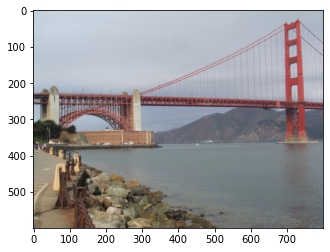

Actual label: 09.Golden_Gate_Bridge
Predicted labels: 09.Golden_Gate_Bridge , 30.Brooklyn_Bridge , 38.Forth_Bridge





In [114]:
# test on a sample image
suggest_locations('./images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The output is better than before. One reason is using pretrained network. Other than that, when we pick top 3 classes, the chances of choosing the correct class becomes much higher than just choosing 1 class.

(Three possible points for improvement)
1. It was seen that the image augmentation has a strong effect on the results of the model. So different augementation schemes and methods can be investigated.
2. Different optimizations should be investigated
3. If more training data is available, the VGG16 model can be more fine tuned with respect to the landmark classification

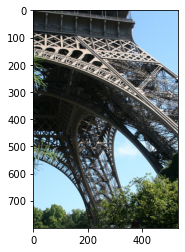

Actual label: 16.Eiffel_Tower
Predicted labels: 16.Eiffel_Tower , 38.Forth_Bridge , 28.Sydney_Harbour_Bridge





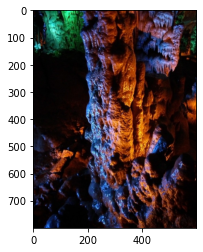

Actual label: 24.Soreq_Cave
Predicted labels: 24.Soreq_Cave , 05.London_Olympic_Stadium , 12.Kantanagar_Temple





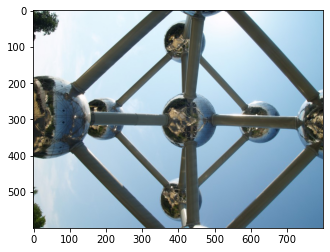

Actual label: 37.Atomium
Predicted labels: 37.Atomium , 22.Moscow_Raceway , 04.Wroclaws_Dwarves





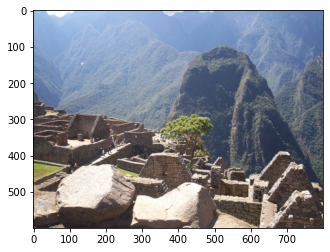

Actual label: 41.Machu_Picchu
Predicted labels: 41.Machu_Picchu , 46.Great_Wall_of_China , 00.Haleakala_National_Park





In [115]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

img_path1 = './images/test/16.Eiffel_Tower/3828627c8730f160.jpg'
img_path2 = './images/test/24.Soreq_Cave/18dbbad48a83a742.jpg'
img_path3 = "./images/test/37.Atomium/5ecb74282baee5aa.jpg"
img_path4 = "./images/test/41.Machu_Picchu/4336abf3179202f2.jpg"

suggest_locations(img_path1)
suggest_locations(img_path2)
suggest_locations(img_path3)
suggest_locations(img_path4)
